In [249]:
# import qiime2
import pandas as pd
import numpy as np
## Used to get rid of warnings
import warnings
warnings.filterwarnings('ignore') 

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt


In [250]:
## DATA PATHS ##
fungi_decontaminated = 'data/count_data_fungi_decontaminated_HMS_1986samples.tsv'
fungi_high_coverage = 'data/count_data_fungi_high_coverage_HMS_1986samples.tsv'
fungi_WSI_intersect = 'data/count_data_fungi_WIS_intersect_HMS_1986samples.tsv'
fungi_metadata = 'data/metadata_fungi_HMS_1986samples.tsv'
tcga_abbrev = 'data/tcga_abbreviations.csv'

In [251]:
## DATA READS ##
fungi_decontaminated = pd.read_csv(fungi_decontaminated, sep='\t', header=0)
fungi_high_coverage = pd.read_csv(fungi_high_coverage, sep='\t', header=0)
fungi_WSI_intersect = pd.read_csv(fungi_WSI_intersect, sep='\t', header=0)
fungi_metadata = pd.read_csv(fungi_metadata, sep='\t', header=0)
tcga_abbrev = pd.read_csv(tcga_abbrev)

#set index as sampleID
fungi_decontaminated = fungi_decontaminated.set_index('sampleid')
fungi_high_coverage = fungi_high_coverage.set_index('sampleid')
fungi_WSI_intersect = fungi_WSI_intersect.set_index('sampleid')
fungi_metadata = fungi_metadata.set_index('sampleid')

In [252]:
## DATA CLEANING/PRE-PROCESSING ##
fungi_metadata_cols = ['disease_type','sample_type'] 
fungi_metadata = fungi_metadata[fungi_metadata_cols] #grab needed columns
fungi_metadata = fungi_metadata[fungi_metadata['sample_type'] == 'Primary Tumor'] #filter only Primary Tumors

min_count = 20 #drop cancers with fewer than 20 samples
fungi_metadata = fungi_metadata[fungi_metadata['disease_type'].map(fungi_metadata['disease_type'].value_counts()) > min_count]
samples = fungi_metadata.index #relevant sampleID's after final cleaning

## DATA FOR ML ##
fungi_decontaminated = fungi_decontaminated.filter(items = samples, axis=0) #filter feature tables for relevant samples
fungi_high_coverage = fungi_high_coverage.filter(items = samples, axis=0)
fungi_WSI_intersect = fungi_WSI_intersect.filter(items = samples, axis=0)
cancer_types = pd.get_dummies(fungi_metadata['disease_type']) #one hot encode disease types

datasets = [ fungi_high_coverage, fungi_WSI_intersect, fungi_decontaminated]

In [253]:
def plot_confidence_interval(x, values, z=1.96, color='#2187bb', horizontal_line_width=0.25):
    mean = np.mean(values)
    stdev = np.std(values)
    confidence_interval = z * stdev / (len(values)**(1/2))

    left = x - horizontal_line_width / 2
    top = mean - confidence_interval
    right = x + horizontal_line_width / 2
    bottom = mean + confidence_interval
    plt.plot([x, x], [top, bottom], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    plt.plot(x, mean, 'o', color=color)

    return mean, confidence_interval


def abbreviate(string, tcga_abbrev):
    abbr = tcga_abbrev[tcga_abbrev['dz'] == string]['abbrev'].values[0]
    return abbr


In [254]:
#check how the validation is being performed. are there pos and neg samples in every fold?

def cross_validation(model, _X, _y, _cv=10):
    
    _scoring = ['roc_auc', 'precision', 'recall']
    
    results = cross_validate(estimator=model,
                            X=_X,
                            y=_y,
                            cv=_cv,
                            scoring=_scoring,
                            return_train_score=True)
    
    return {"Training ROC_AUC scores": results['train_roc_auc'],
          #"Mean Training ROC_AUC": results['train_roc_auc'].mean()*100,
          "Training Precision scores": results['train_precision'],
          #"Mean Training Precision": results['train_precision'].mean(),
          "Training Recall scores": results['train_recall'],
          #"Mean Training Recall": results['train_recall'].mean(),
          "Validation ROC_AUC scores": results['test_roc_auc'],
          #"Mean Validation ROC_AUC": results['test_roc_auc'].mean()*100,
          "Validation Precision scores": results['test_precision'],
          #"Mean Validation Precision": results['test_precision'].mean(),
          "Validation Recall scores": results['test_recall'],
          #"Mean Validation Recall": results['test_recall'].mean()
          }


In [255]:
## BUILD MODEL ##

#TODO: define cross validation hyperparams

#TODO: define model hyperparams, can automate tuning later
random_state = 0 #DO NOT TOUCH
n_estimators = 150
max_depth = 3

#TODO: implement model(s)
clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)

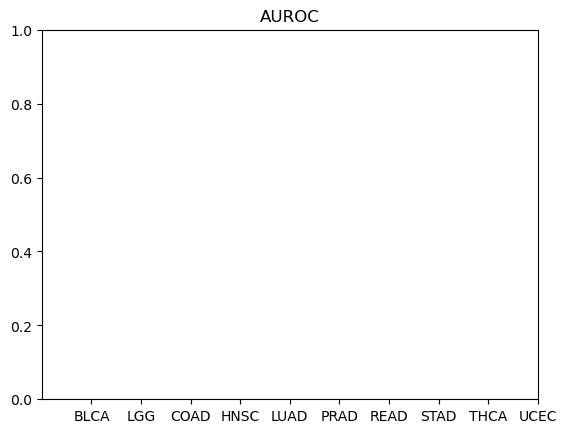

In [256]:
## INITIALIZE PLOT ##
x_ticks = plt.xticks(range(1, len(cancer_types.columns)+1), [abbreviate(cancer,tcga_abbrev) for cancer in cancer_types.columns])
title = plt.title('AUROC')

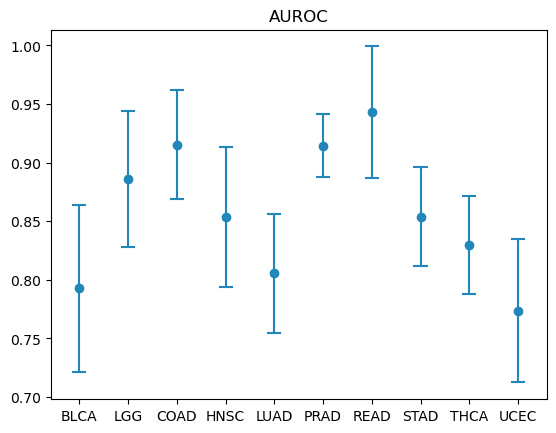

In [257]:
X = fungi_decontaminated
for i, cancer in enumerate(cancer_types.columns, start=1):
            y = cancer_types[cancer].values #array format for cross validation

            clf_result = cross_validation(clf, X, y)

            plt_data = clf_result['Validation ROC_AUC scores']
            plot_confidence_interval(i, plt_data)
            
            #TODO: implement code to organize store predictions
x_ticks = plt.xticks(range(1, len(cancer_types.columns)+1), [abbreviate(cancer,tcga_abbrev) for cancer in cancer_types.columns])
title = plt.title('AUROC')            
plt.show()

In [258]:
colors = ['red','blue','orange']

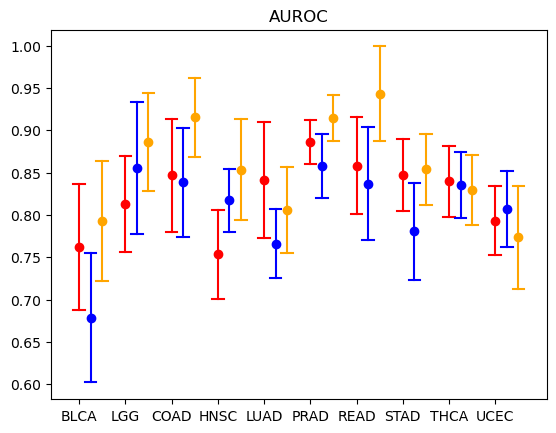

In [259]:
## AUTOMATION TIME! ##
x_loc = 0
for data in range(len(datasets)):
    
    X = datasets[data]
    color = colors[data]
    
    if data > 0 :
        x_loc += .25
    for i, cancer in enumerate(cancer_types.columns, start=1):

            y = cancer_types[cancer].values #array format for cross validation

            clf_result = cross_validation(clf, X, y,)
            plt_data = clf_result['Validation ROC_AUC scores']
            
            plot_confidence_interval(i+x_loc, plt_data,color=color)
            
            #TODO: implement code to organize store predictions
            
x_ticks = plt.xticks(range(1, len(cancer_types.columns)+1), [abbreviate(cancer,tcga_abbrev) for cancer in cancer_types.columns])
title = plt.title('AUROC')
plt.show()